# PINN Solver for Dehnen profile

## 1. Introduction
We start from the Dehnen density profile $$\rho(r) = \dfrac{(3-\gamma)M}{4\pi}\dfrac{a}{r^{\gamma}(r+a)^{4-\gamma}} $$
For $\gamma=1$ and $\gamma=2$ we recover the Hernquist and Jaffe profiles, respectively. Note that the parameter $\gamma$ is restriced to the interval $[0, 3)$.

We note that it is convenient to use the expression of Dehnen density profile given in Binnet et ... :

$$\rho(r) = \dfrac{\rho_0}{\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}} = \dfrac{M}{2\pi a^3}\dfrac{1}{\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}}$$  as $M=2\pi a^3 \rho_0$

### 1.1 The equation to solve
For such a potential, the Poisson equation reads:
$$\nabla ^2 \phi = 4\pi G \rho$$

$$ \Leftrightarrow \dfrac{1}{r^2} \dfrac{\partial}{\partial r}\left(r^2 \dfrac{\partial \phi}{\partial r}\right) = 4\pi G \left[\dfrac{M}{2\pi a^3}\dfrac{1}{\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}}\right]$$ 

Given that the density-potential pair depends solely on the radial coordinate $r$, the equation reduces to

$$  \dfrac{1}{r^2} \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2GM}{a^3\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}}$$


Setting $s \rightarrow \frac{r}{a}$, we get
$$  \dfrac{1}{a^2 s^2}\dfrac{d}{a ds}\left(a^2 s^2 \dfrac{d \phi}{a ds}\right) = \dfrac{2GM}{a^3 s^{\gamma}(1+s)^{4-\gamma}}$$


Finally, in the case of the Dehnen profile, the Poisson equation can be written such as:

$$ \boxed{\dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2r^{2-\gamma}}{(1+r)^{4-\gamma}}}$$

where we have set $\frac{GM}{a}$ to unity and changed back $s$ to $r$.

The potential can be computed analytically and is given by:

$$ \boxed{ \Phi(s) = -\dfrac{1}{2 - \gamma} \left[1 - \left( \dfrac{s}{1 + s} \right )^{2-\gamma}\right]}$$

and in the particular case $\gamma = 2$, this is Jaffe's model with :

$$\boxed{\Phi(s) = \ln\left( \dfrac{s}{1 + s}\right)}$$

### 1.2 Initial conditions

Given the expression of the potential, the training domain cannot start at $s=0$. It would diverge for $\gamma=2$. We therefore have to give it a small 

## 2. Structure of the PINN

Whereas for the Hernquist profile we used the neural network as an approximation of a function $f$ taking as an input only spatial coordinates $r$, we want now the network to take an extra parameter $\gamma$ such as $f(r, \gamma)$.

**Loss function for the Poisson equation**

In our case, we do not consider any data points. Therefore $N_d$ = 0 and $\mathcal{L}_{data}(\theta)=0$. Also we consider for now that $\omega_{\mathcal{F}} = \omega_{\mathcal{B}} = 1$. Finally, we consider in the training a 1-D domain, with $N_c = 1000$ and $N_B = 1$.

We note that here, the residual $r_{\theta} (z)$ is as follow :

$$ r_{\theta} (z) = \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) - \dfrac{2r^{2-\gamma}}{(1+r)^{4-\gamma}}$$

Therefore, we want to minimize the following loss function :

$$ \mathcal{L}(\theta) = \dfrac{1}{N_c}\sum^{N_c}_{i=1} \left\|\dfrac{df}{d r} - \dfrac{2r^{2-\gamma}}{(1+r)^{4-\gamma}} - r_i \right\|^2 + \dfrac{1}{N_B}\sum^{N_B}_{i=1} \left\|\hat{u}(z_0) - u_0\right\|^2$$ 

where we set $f = r^2 \dfrac{d \phi}{d r}$. 

### 2.1 PINN input

The PINN has to be able to learn over a wide dynamic range. Where at large radii, the potential vanishes, at small radii the behaviour strongly depends on the value of $\gamma$. In order for the PINN to learn this behaviour, we now try to give as input a grid $\gamma \in [0, 3) \times [x_i, x_f]$ where $x_i$ and $x_f$ are the initial and final points of the spatial domain. In this configuration, the network will see the behaviour of the potnetial for each $\gamma$, and at each value of $x_n$.

### 2.2 PINN output

The output of the PINN is $f(x_n, \gamma_n)$, the approximation of the gravitational potential at any point $x_n$ for a given value $\gamma_n$.

https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html

In [1]:
import torch
import numpy as np
from torch import nn, optim
from tqdm.notebook import tqdm, trange
from pyDOE import lhs 

In [2]:
def dehnen(radius, gamma, scale_factor=1):
    """ Value of the gravitational potential
        in the case of a Dehnen profile
    """
    #if gamma == 2:
        #return np.log(radius / (radius + scale_factor))
    power1 = 2 - gamma
    return -1 / power1 * (1 - (radius / (radius + scale_factor)) ** power1)

In [94]:
steps = 50_000
lr = 1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min = 1e-2
x_max = 10
gamma_min = 0
gamma_max = 2.99
total_points_x = 200
total_points_gamma = 100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu = 100
Nf = 10000

In [4]:
class FCN(nn.Module):
    # https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    # Neural Network
    def __init__(self, _layers):
        super().__init__()  # call __init__ from parent class
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(_layers[i], _layers[i + 1]) for i in range(len(_layers) - 1)])
        self.iter = 0  # For the Optimizer
        for i in range(len(_layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, _x):
        if not torch.is_tensor(_x):
            _x = torch.from_numpy(_x)
        a = _x.float()
        for i in range(len(layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def lossBC(self, x_BC, y_BC):
        loss_BC = self.loss_function(self.forward(x_BC), y_BC)
        return loss_BC

    def lossPDE(self, x_PDE):
        _x, _gamma = x_PDE[:, 0].unsqueeze(1), x_PDE[:, 1].unsqueeze(1)
        x_PDE.requires_grad = True  # Enable differentiation
        f = self.forward(x_PDE)
        f_x = torch.autograd.grad(f, x_PDE, torch.ones(x_PDE.shape[0], 1), retain_graph=True, create_graph=True)[0]
        f_x = f_x[:, 0].unsqueeze(1)
        func = f_x * _x ** 2
        f_xx = torch.autograd.grad(func, x_PDE, torch.ones(x_PDE.shape[0], 1), retain_graph=True, create_graph=True)[0]
        power1 = 2 - _gamma
        power2 = 4 - _gamma
        cout = f_xx - (2 * _x ** power1) / (_x + 1) ** power2
        return self.loss_function(cout, f_hat)

    def loss(self, x_BC, y_BC, x_PDE):
        loss_bc = self.lossBC(x_BC, y_BC)
        loss_pde = self.lossPDE(x_PDE)
        return loss_bc + loss_pde

    # Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf
    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(X_train_Nu, Y_train_Nu, X_train_Nf)
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            loss2 = self.lossBC(X_test, Y_test)
            print("Training Error:", loss.detach().cpu().numpy(), "---Testing Error:", loss2.detach().cpu().numpy())
        return loss

In [12]:
x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
gamma = torch.linspace(gamma_min, gamma_max, total_points_gamma).view(-1,1)
# Create the mesh 
X,GAMMA = torch.meshgrid(x.squeeze(1), gamma.squeeze(1), indexing='xy')
y_real = dehnen(X,GAMMA)
# plot3D(x, gamma, y_real)

## Initial Conditions

In [13]:
print(x.shape, gamma.shape)
print(X.shape, GAMMA.shape)

torch.Size([200, 1]) torch.Size([100, 1])
torch.Size([100, 200]) torch.Size([100, 200])


### Left Boundary

In [23]:
left_X = torch.hstack((X[:, 0][:,None],GAMMA[:, 0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y = dehnen(left_X[:,0], GAMMA[:,0]).unsqueeze(1)

### Bottom Boundary

In [37]:
bottom_X = torch.hstack((X[0,:][:,None],GAMMA[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y = dehnen(bottom_X[:, 0], GAMMA[0, :]).unsqueeze(1)

### Upper Boundary

In [49]:
top_X = torch.hstack((X[-1,:][:,None],GAMMA[-1, :][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y = dehnen(top_X[:, 0], GAMMA[-1, :]).unsqueeze(1)

### Right Boundary

In [58]:
right_X = torch.hstack((X[:, -1][:,None],GAMMA[:, -1][:,None]))
right_Y = dehnen(right_X[:, 0], GAMMA[:, 0]).unsqueeze(1)

In [60]:
# Transform the mesh into a 2-column vector
x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],GAMMA.transpose(1,0).flatten()[:,None]))
y_test = y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb = x_test[0]  # first value
ub = x_test[-1] # last value 
print(x_test.shape, y_test.shape)
print(lb, ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([0.0100, 0.0000]) tensor([10.0000,  2.9900])


In [59]:
X_train = torch.vstack([left_X,bottom_X,top_X, right_X])
Y_train = torch.vstack([left_Y,bottom_Y,top_Y, right_Y])
#Choose(Nu) points of our available training data:
idx = np.random.choice(X_train.shape[0] , Nu, replace=False)
X_train_Nu = X_train[idx,:]
Y_train_Nu = Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf = lb + (ub - lb) * lhs(2, Nf) # 2 as the inputs are x and t
X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu)) # Add the training points to the collocation point

In [61]:
%%time
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu = X_train_Nu.float() # Training Points (BC)
Y_train_Nu = Y_train_Nu.float() # Training Points (BC)
X_train_Nf = X_train_Nf.float() # Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1)#to minimize function

X_test = x_test.float() # the input dataset (complete)
Y_test = y_test.float() # the real solution 


#Create Model
PINN = FCN(layers)

print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
CPU times: user 3.6 ms, sys: 4.73 ms, total: 8.32 ms
Wall time: 15 ms


"\n'L-BFGS Optimizer'\noptimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, \n                              max_iter = steps, \n                              max_eval = None, \n                              tolerance_grad = 1e-05, \n                              tolerance_change = 1e-09, \n                              history_size = 100, \n                              line_search_fn = 'strong_wolfe')"

In [95]:
losses = []
for i in range(steps):
    if i==0:
        print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
        with torch.no_grad():
            test_loss = PINN.lossBC(X_test,Y_test)
        print(loss.detach().numpy(),'---',test_loss.detach().numpy())

Training Loss-----Test Loss
0.70358706 --- 0.8962765


/Users/lucas/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10100, 1])) that is different to the input size (torch.Size([10100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.66268504 --- 1.3575728
0.6799263 --- 1.6574131
0.62527376 --- 1.9252942
0.5934977 --- 2.1799145
0.57997453 --- 2.4241798
0.56842965 --- 2.633283
0.5605467 --- 2.7581966
0.5499083 --- 2.8683152
0.5395157 --- 2.9488387


In [100]:
losses = [t.detach() for t in losses]

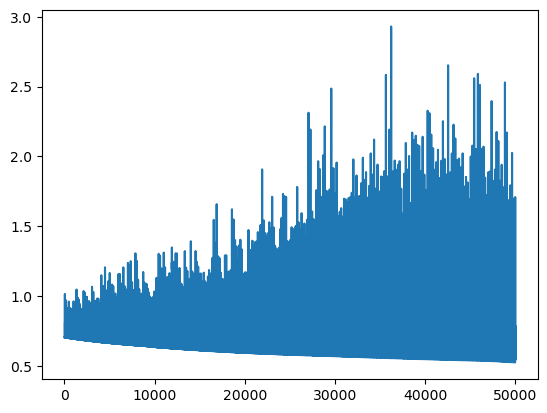

In [101]:
plt.plot(losses)

In [102]:
y1 = PINN(X_test)
x1 = X_test[:,0]
t1 = X_test[:,1]

In [103]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

In [104]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

def plot3D(x,t,y):
    x_plot =x.squeeze(1) 
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot)
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

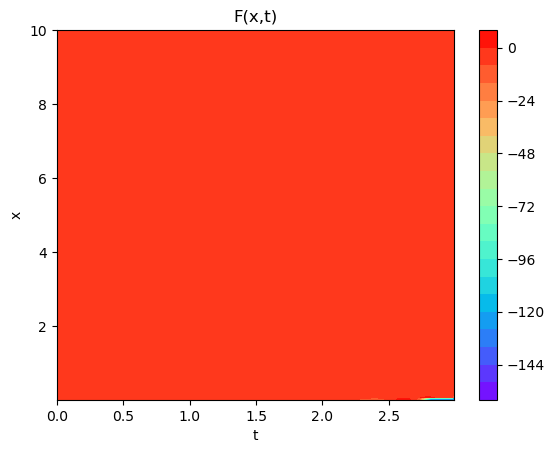

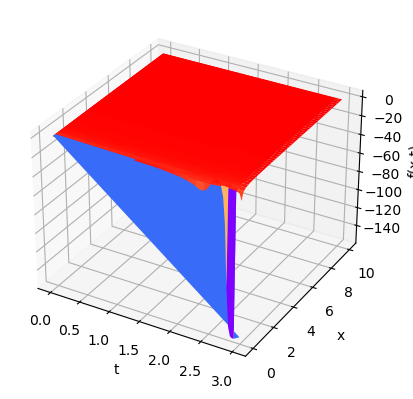

In [105]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

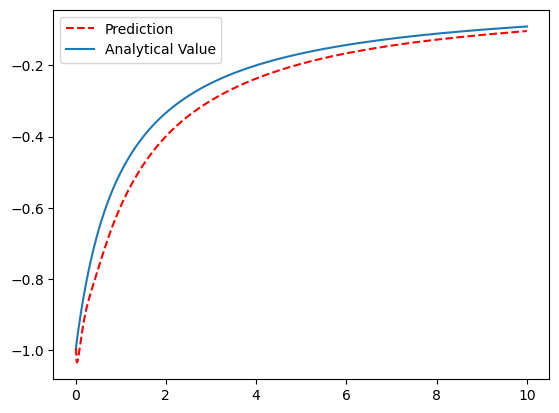

In [111]:
gamma = 1
num_points = 1000
domain = np.linspace(x_min, x_max, num_points)
x_test = np.array([domain, np.ones(num_points) * gamma])

y_pred = PINN(x_test.T)

plt.plot(domain, y_pred.detach().numpy(), '--r', label="Prediction")
plt.plot(domain, dehnen(domain, gamma), label="Analytical Value")
plt.legend();